## Identification of sustainability-focused campaigns on the kickstarter crowdfunding platform using NLP and ML boosted with swarm intelligence
--- ------------------
<div>
Data Analysis: part 1
<br>
Submitted by: Jossin Antony<br>
Affiliation: THU Ulm<br>
Date: 11.06.2024
</div>

## Overview
- [Introduction](#Introduction)
- [Details of dataset](#Details-of-dataset:)
- [Preparation of Dataset](#Preparation-of-Dataset)
- [Save dataset](#Save-dataset)

### Introduction
--- -------------------

The aim of the project is to study how crowdfunding campaigns support sustainable inititatives. This project, in particular, focuses on crowdfunded campaigns in the [kickstarter](https://www.kickstarter.com/) platform and explores a dataset of c.a 184,185 initiatives from different domains (e.g, Technology, Music, Publishing etc.). The goal of the analyses here is to find the most important features that are relevant to initiatives that are both sustainable as well as profitable. The analyses will also explore the possible relationship of the features with each other, and elucidate insights that might contribute to better understanding of the success/failure propsects of current and future environment focused crowdfunded initiatives.


#### Details of dataset:
-- -------------------
1. Source: [Kickstarter_File.xlsx](Kickstarter_File.xlsx)
2. Generation mode: provided by researcher
3. Time period considered: 04-2009 to 05-2021 (c.a 146 months).
4. Total entries: 184,185

The initial data preparation consists of examining the various features and eliminating redundant features & renaming and re-ordering of features and saving the dataframe.

### Preparation of Dataset
--- ------------------

First we make sure the dataset is 'reasonable', i.e, it has good structure, columns have data of expected types, devoid of null values etc.

The basic information of the data is as following:

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from langdetect import detect
import numpy as np
import re
from pprint import PrettyPrinter
from matplotlib import pyplot as plt
pp=PrettyPrinter()

In [3]:
#load the raw dataset from excel file. This is slow.
#df= pd.read_excel('./data/Kickstarter_File.xlsx')
#--------------------------------------------------
#write the raw dataset as a data frame in a csv file. Do this only once, if the dataframe file is not provided already.
#df.dropna(how='all', inplace=True)
#df.to_csv('./data/dataframe_raw.csv', index=False)
#--------------------------------------------------
#load the raw dataset from the data frame csv file, ONCE file is already created. This is fast as compared to reading from excel file.
df= pd.read_csv('./data/dataframe_raw.csv', low_memory=False)


In [3]:
df.rename_axis('index',inplace=True)
shape= df.shape
print(f'The dataframe has {shape[0]} rows and {shape[1]} columns.')
print()
print('The overall dataframe information is given below:')
print(df.info())

print()

print("We also make the preliminary observation that the columns named 'environmental', 'social' and 'unnamed: 5' \
have lots of 'NaN' values. We will deal with them later.")

The dataframe has 184187 rows and 24 columns.

The overall dataframe information is given below:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184187 entries, 0 to 184186
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   blurb                     184184 non-null  object 
 1   Environmental             2053 non-null    object 
 2   Social                    2053 non-null    object 
 3   state                     184186 non-null  object 
 4   Subcategory               184186 non-null  object 
 5   Unnamed: 5                176465 non-null  object 
 6   converted_pledged_amount  184186 non-null  float64
 7   country                   184186 non-null  object 
 8   country_displayable_name  184186 non-null  object 
 9   created_at                184186 non-null  object 
 10  currency                  184186 non-null  object 
 11  deadline                  184186 non-null  object 
 12  fx_

Next we provide meaningful names to the columns to reflect the nature of the data they contain as well as re-order them.

In [14]:
x=df['created_at'].apply(lambda x: str(x)[:4]).value_counts()
x

created_at
2015    29070
2016    23015
2014    22204
2020    21509
2017    21460
2019    19818
2018    19119
2013    10043
2012     7243
2021     5136
2011     3915
2010     1412
2009      242
nan         1
Name: count, dtype: int64

In [4]:
#Rename the columns to meaningful names
df.rename(columns={'Environmental':'is_environmental',
                   'Social':'is_social',
                   'state':'is_success',
                   'country':'country_code',
                   'Unnamed: 5':'main_category',
                   'Subcategory':'sub_category',
                   'converted_pledged_amount':'pledged_amount_usd',
                   'goal':'goal_in_local_currency',
                   'duration':'duration_in_days',
                   'name':'campaign_name',
                   'pledged':'pledged_in_local_currency',
                   },inplace=True)
#Reorder the columns
df=df[['campaign_name', 
       'blurb', 
       'slug', 
       'main_category',
       'sub_category', 
       'is_environmental', 
       'is_social', 
       'country_code', 
       'country_displayable_name', 
       'created_at', 
       'launched_at', 
       'deadline', 
       'duration_in_days', 
       'currency', 
       'goal_in_local_currency', 
       'pledged_in_local_currency', 
       'usd_pledged',
       'pledged_amount_usd', 
       'staff_pick', 
       'state.1', 
       'fx_rate', 
       'static_usd_rate', 
       'usd_exchange_rate',
       'is_success',]]

In [5]:
pp.pprint('The new column_names are:');pp.pprint(list(df.columns))

'The new column_names are:'
['campaign_name',
 'blurb',
 'slug',
 'main_category',
 'sub_category',
 'is_environmental',
 'is_social',
 'country_code',
 'country_displayable_name',
 'created_at',
 'launched_at',
 'deadline',
 'duration_in_days',
 'currency',
 'goal_in_local_currency',
 'pledged_in_local_currency',
 'usd_pledged',
 'pledged_amount_usd',
 'staff_pick',
 'state.1',
 'fx_rate',
 'static_usd_rate',
 'usd_exchange_rate',
 'is_success']


Next we drop the columns which are redundant or which do not add any value to the analysis. The dropped columns are as following:

1. <b>'country' and 'country_displayable_name':</b>

    We need only one of these; but we save the country codes for later reference.

2. <b>'created_at', 'launched_at', 'deadline', 'duration':</b>

    There is no discernible difference between 'created_at' and 'launched_at' since they are, at maximum, only few days apart in order to have an effect on the results we look for. 'duration' provides the difference in days between launched_at and deadline and we keep this parameter (for now).

3. <b>'currency', 'goal_in_local_currency', 'pledged_in_local_currency', 'usd_pledged','converted_pledged_amount_usd', 'fx_rate', 'static_usd_rate', 'usd_exchange_rate':</b>

    There is the goal- but only in local currency- and the pledged amount- in both local currency and usd. 
    We add a new column, 'goal_in_usd', which gives the goal in usd as well. It is obtained by multiplying the 'goal_in_local_currency' with the provided 'usd_exchange_rate' (Logic: The converted_pledged_amount_usd is provided by the author as a product of 'usd_exchange_rate' and 'pledged_in_local_currency').

4. <b>'staff_pick' and 'state.1':</b>
    These columns are dropped, since state.1 is a reptition of the column 'is_success' and 'staff_pick' do not seem to add value to the analysis at hand.

5. <b>'slug' and 'campaign_name':</b>
    'slug'is a repetition of 'campaign_name', it is dropped.

In [6]:
#Drop columns which do not add value to the analysis
#---------------------------------------------------
#1. 'country' and 'country_displayable_name'.
# We need only on of these; but save the country codes for later reference.
df[['country_displayable_name','country_code']].drop_duplicates().reset_index(drop=True).to_csv('./data/country_codes.txt',sep='\t', index=False),

#---------------------------------------------------
#2. 'created_at', 'launched_at', 'deadline', 'duration'
# There is no discernible difference between created_at and launched_at since they are, at maximum, only few days apart in oorder to have an 
#effect on the results we look for. duration provides the difference in days between launched_at and deadline and we keep this parameter (for now).

#-------------------------------------------------
#3. 'currency', 'goal_in_local_currency', 'pledged_in_local_currency', 'usd_pledged', 'converted_pledged_amount_usd',
# 'fx_rate', 'static_usd_rate', 'usd_exchange_rate'
# There is the goal- but only in local currency- and the pledged amount- in both local currency and usd. 
# We add a new column, 'goal_in_usd', which gives the goal in usd as well. It is obtained by multiplying the 'goal_in_local_currency' with
# the provided 'usd_exchange_rate' (Logic: The converted_pledged_amount_usd is provided by the author as a product of 'usd_exchange_rate' 
# and pledged_i'n_local_currency).
df['goal_usd']= df['goal_in_local_currency']*df['usd_exchange_rate'] 
#We retain, in the end, 'goal_in_usd' and 'converted_pledged_amount_usd' and drop other currency, exchange rates and goal and pledged amounts
#in local currency.

#-------------------------------------------------
#4. 'staff_pick' and 'state.1'
# These columns are dropped, since state.1 is a reptition of the column 'is_success' and 'staff_pick' do not seem to add value to the 
#analysis at hand.

#-------------------------------------------------
#5. 'slug' and 'campaign_name'
# 'slug'is a repetition of 'campaign_name', it is dropped.

#-------------------------------------------------
#Drop unwanted columns
columns_to_drop= ['country_displayable_name', 
       'slug',
       'created_at', 
       'launched_at', 
       'deadline', 
       'currency', 
       'goal_in_local_currency', 
       'pledged_in_local_currency', 
       'usd_pledged',
       'staff_pick', 
       'state.1', 
       'fx_rate', 
       'static_usd_rate', 
       'usd_exchange_rate',]
for column in columns_to_drop:
       if column in df.columns:
              df.drop(column, axis=1, inplace=True)

#-------------------------------------------------
#Reorder columns
df=df[['campaign_name', 
       'blurb',
       'main_category', 
       'sub_category', 
       'is_environmental', 
       'is_social', 
       'country_code', 
       'duration_in_days', 
       'goal_usd',
       'pledged_amount_usd', 
       'is_success', 
       ]]
#Round floating number values to 2
df=df.round(2)

In [7]:
print('Overview of the selected features:\n','\n'.join(list(df.columns)))

Overview of the selected features:
 campaign_name
blurb
main_category
sub_category
is_environmental
is_social
country_code
duration_in_days
goal_usd
pledged_amount_usd
is_success


We also drop the rows which have 'NaN' values in more than 3 columns.

Note: We expect 'NaN' values in atleast 2 columns, is_envt and is_social.

In [27]:
df=df[df.isna().sum(axis=1) <= 3]

Next we remove those rows which do not have the 'campaign_name','blurb', 'main_category', 'sub_category', in the expected string format.

We also remove the rows where the columns 'duration_in_days','goal_usd', 'pledged_amount_usd' also do not have data in the expected number format. 

We also strip spaces from 'main_category', 'sub_category' and 'country' columns.


In [28]:
columns= ['campaign_name','blurb', 'main_category', 'sub_category']
is_str= df[columns].map(lambda x: isinstance(x, str))
all_str= is_str.all(axis=1)
df=df[all_str]

columns= ['duration_in_days','goal_usd', 'pledged_amount_usd']
is_nbr= df[columns].map(lambda x: isinstance(x, (int,float)))
all_nbr= is_nbr.all(axis=1)
df=df[all_nbr]

df['main_category'] = df['main_category'].apply(lambda x: x.strip())
df['sub_category'] = df['sub_category'].apply(lambda x: x.strip())

df['country_code'] = df['country_code'].apply(lambda x: x.strip())

We replace the duration in days with duration in months, rounded to the nearest month.

In [29]:
df['duration_in_days']=(df['duration_in_days']/30).round().astype(int)
df.rename(columns={'duration_in_days':'duration_in_months'}, inplace=True)

In [30]:
print(f'{df['duration_in_months'].value_counts()}')

duration_in_months
1    136022
2     29238
0     10861
3       341
4         1
Name: count, dtype: int64


We observe that the values of the 'duration' are reasonable within the scope of the project.

**Important:**
<font style="color:red">
We consider campaigns where the goal is atleast USD 1000.
</font>

In [31]:
df[['duration_in_months','goal_usd', 'pledged_amount_usd']]= df[['duration_in_months','goal_usd', 'pledged_amount_usd']].round().astype(int)
df=df[df['goal_usd']>=1000]

We now observe how much percentage of the funding were acquired by the campaigns.

In [32]:
df['funding_percent']= ((df['pledged_amount_usd']/df['goal_usd'])*100).round().astype(int)

We now observe the Histogram.

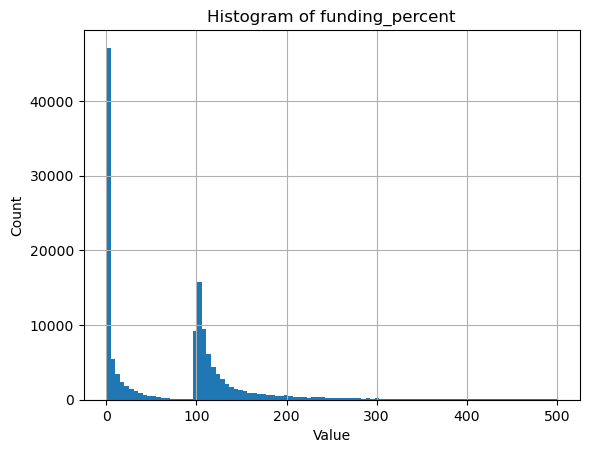

In [33]:
bins = np.linspace(0, 500,100)

# Plotting the histogram with specified bins
df['funding_percent'].hist(bins=bins)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of funding_percent')
plt.show()

From the histogram, we discern that there can be 3 different categories for the is_success status. These are:
- funding_percent < 100%: failure
- 100% <= funding_percent < 300%: success
- funding_percent >= 300%: blockbuster

In [34]:
conditions = [
    df['funding_percent'] < 100,
    (df['funding_percent']>=100) & (df['funding_percent']<300),
    df['funding_percent'] >= 300,
]

choices = [
    'fail',  
    'goal_achieved',
    'blockbuster'
]

df['is_success'] = np.select(conditions, choices, default='Unknown')

In [35]:
df['is_success'].value_counts()

is_success
goal_achieved    70357
fail             66720
blockbuster       8779
Name: count, dtype: int64

We also categorize the campaign goal based on the amount. Perhaps, we observe later trends with respect to goal amounts and the chances of campaigns being successful.

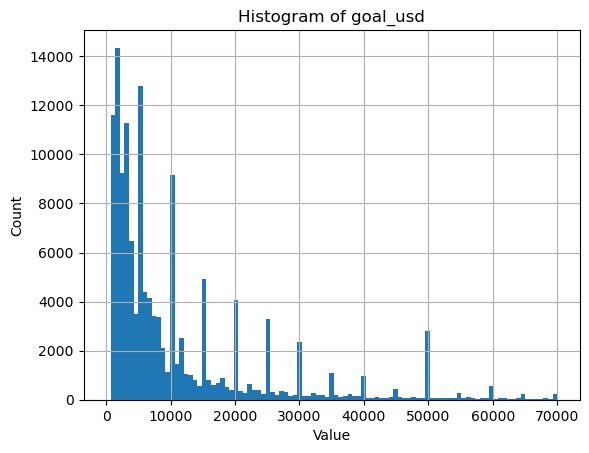

In [36]:
bins = np.linspace(1, 70000,100)

# Plotting the histogram with specified bins
df['goal_usd'].hist(bins=bins)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of goal_usd')
plt.show()

The histogram shows that the goal amounts are centered on multiples of 5000s. The majority of the campaigns aim to raise an amount less than USD 50,000. The follwing categories are defined:
- 1000 <= goal_usd < 10,000: 1k-10k
- 10,000 <= goal_usd < 50,000: 10k-50k
- goal_usd > 50,000: 50k_plus

In [37]:
conditions = [
    (df['goal_usd']>=1000) & (df['goal_usd']<10000),
    (df['goal_usd']>=10000) & (df['goal_usd']<50000),
    (df['goal_usd']>=50000),
]

choices = [
    '1k-10k',  
    '10k-50k',
    '50k_plus',
]

df['goal_usd_category'] = np.select(conditions, choices, default='Unknown')


We now drop the 'goal_usd', 'pledged_amount_usd' and 'funding_percent' columns since the information in these columns are captureed in the 'goal_usd_category' and 'is_success' columns respectively. 

In [38]:
df.drop(columns=['goal_usd', 'pledged_amount_usd', 'funding_percent'], inplace=True)
#Reorder columns
df=df[['campaign_name', 
       'blurb',
       'main_category', 
       'sub_category', 
       'is_environmental', 
       'is_social', 
       'country_code', 
       'duration_in_months', 
       'goal_usd_category', 
       'is_success', 
       ]]

We also consider only those rows which are in english language. We first remove rows whose descriptions do not appear in latin script. Further more, we delete rows which contain only links. We also try to deduce the language of the description and retain only those rows whose description is provided in english.
Note:
- The rows containing only links for description are found using a url_regex. It is not perfect and cannot detect all rows with urls only. We resort to manualk deletion of such rows (In our case: 1 row only).
- The detection of languages is implemented by the [langdetect](https://pypi.org/project/langdetect/) package. It also provide false negatives. But since these are negligeble compared to the total data corpus, we disregard the false negatives.

In [39]:
#check that the descriptions contain only latin script
df['sane_descriptors']= df[['blurb','campaign_name']].apply(lambda row: 'yes' if bool(re.match('^(?=.*[a-zA-Z])', row['blurb'])) and bool(re.match('^(?=.*[a-zA-Z])', row['campaign_name'])) else 'no', axis= 1)
df = df[df['sane_descriptors'] == 'yes']
df.drop('sane_descriptors', axis=1, inplace=True)

#Remove rows which contain only links for descriptions
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
#warning: this does not capture all the links only, but majority of them.
df= df[~df['blurb'].str.contains('^'+url_regex+'$', na=False)]

#Some rows are removed manually, so that it does not interfere with 
#the detect()function which captures the language.
df=df.drop(10795,axis=0) #The description has only links chained after one another and not captured by url_regex

df = df.reset_index(drop=True)
#Implement langdetect in batches
batch_size= 3000
num_batches= (len(df)//batch_size)+1

for i in range(num_batches):
    start_index= i*batch_size
    end_index= (i+1)*batch_size if (i+1)*batch_size < len(df) else len(df)
    
    print(f'Batch: {i}, Rows: {start_index}-{end_index}')
    df.loc[start_index:end_index, 'language']= df.loc[start_index:end_index]['blurb'].apply(
        lambda row: detect(row))


Batch: 0, Rows: 0-3000
Batch: 1, Rows: 3000-6000
Batch: 2, Rows: 6000-9000
Batch: 3, Rows: 9000-12000
Batch: 4, Rows: 12000-15000
Batch: 5, Rows: 15000-18000
Batch: 6, Rows: 18000-21000
Batch: 7, Rows: 21000-24000
Batch: 8, Rows: 24000-27000
Batch: 9, Rows: 27000-30000
Batch: 10, Rows: 30000-33000
Batch: 11, Rows: 33000-36000
Batch: 12, Rows: 36000-39000
Batch: 13, Rows: 39000-42000
Batch: 14, Rows: 42000-45000
Batch: 15, Rows: 45000-48000
Batch: 16, Rows: 48000-51000
Batch: 17, Rows: 51000-54000
Batch: 18, Rows: 54000-57000
Batch: 19, Rows: 57000-60000
Batch: 20, Rows: 60000-63000
Batch: 21, Rows: 63000-66000
Batch: 22, Rows: 66000-69000
Batch: 23, Rows: 69000-72000
Batch: 24, Rows: 72000-75000
Batch: 25, Rows: 75000-78000
Batch: 26, Rows: 78000-81000
Batch: 27, Rows: 81000-84000
Batch: 28, Rows: 84000-87000
Batch: 29, Rows: 87000-90000
Batch: 30, Rows: 90000-93000
Batch: 31, Rows: 93000-96000
Batch: 32, Rows: 96000-99000
Batch: 33, Rows: 99000-102000
Batch: 34, Rows: 102000-105000
Ba

Now we check if there are any unprocessed rows. If yes, detect the language in these rows.

In [40]:
print(f'''Processed samples: {df['language'].value_counts().sum()}
Empty/Unprocessed values: {df['language'].isna().sum()}
Samples with non-english descriptions: {len(df[df['language']!='en'])}''')
    

Processed samples: 145791
Empty/Unprocessed values: 0
Samples with non-english descriptions: 6177


We remove the rows whose descriptions are not in english.

In [41]:
#df[df['language']!='en'].sample(50)
#print(f'There are {df[df['language']!='en'].shape[0]} samples with non-english descriptions.')
df= df[df['language']=='en']
df.drop('language', axis= 1, inplace=True)
#Reset index
df= df.reset_index(drop=True)
print(f'The final dataset has {len(df)} samples.')

The final dataset has 139614 samples.


In [42]:
print(f'The columns in the dataset are:','\n','\n'.join(list(df.columns)))

The columns in the dataset are: 
 campaign_name
blurb
main_category
sub_category
is_environmental
is_social
country_code
duration_in_months
goal_usd_category
is_success


There are 'NaN' values for the 'is_envt' and 'is_social' categories. We will populate them in the next set of analyses.

<a id="save-dataset"></a>
### Save dataset
--- -------------------

After this we save the data to a local file for the next set of analyses.

In [43]:
#Save the processed data
df.dropna(how='all', inplace=True)
df.to_csv('./data/dataframe_stripped_features.csv', index=False)

In [560]:
!jupyter nbconvert --to webpdf 01.Dataset_Prep.ipynb --no-input

[NbConvertApp] Converting notebook 01.Dataset_Prep.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 108484 bytes to 01.Dataset_Prep.pdf
Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Connection.run() running at C:\Users\Ronin\miniforge3\envs\dl4cv\Lib\site-packages\playwright\_impl\_connection.py:274> wait_for=<Future pending cb=[Task.task_wakeup()]>>
Exception ignored in: <function _ProactorBasePipeTransport.__del__ at 0x00000210B993DA80>
Traceback (most recent call last):
  File "C:\Users\Ronin\miniforge3\envs\dl4cv\Lib\asyncio\proactor_events.py", line 116, in __del__
    _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
                               ^^^^^^^^
  File "C:\Users\Ronin\miniforge3\envs\dl4cv\Lib\asyncio\proactor_events.py", line 80, in __repr__
    info.append(f'fd={self._sock.fileno()}')
         